In [1]:
import ete3
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import subprocess
from scipy.stats import spearmanr, linregress
import itertools
from Bio import SeqIO, SearchIO, AlignIO, Align, Alphabet
import re
import multiprocessing
from copy import deepcopy

class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

os.chdir('/work/site_rate/abg')
ncbi        = ete3.NCBITaxa()
num_threads = 10

In [2]:
header = '''assembly_accession bioproject biosample wgs_master refseq_category taxid species_taxid
            organism_name infraspecific_name isolate version_status assembly_level release_type 
            genome_rep seq_rel_date asm_name submitter gbrs_paired_asm paired_asm_comp ftp_path
            excluded_from_refseq relation_to_type_material'''.split()

genbank_summary = pd.read_table('/work/assembly_summary_genbank.txt',
                                comment='#', header=None, names=header,
                                dtype={'taxid':str, 'infraspecific_name':str})
genbank_summary.set_index('assembly_accession', inplace=True)

refseq_summary  = pd.read_table('/work/assembly_summary_refseq.txt',
                                comment='#', header=None, names=header,
                                dtype={'taxid':str, 'infraspecific_name':str})
refseq_summary.set_index('assembly_accession', inplace=True)

assembly_summary = genbank_summary.append(refseq_summary)
del(refseq_summary)
del(genbank_summary)

/Users/thiberio/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
tree             = ete3.Tree('euk_partition_file.txt.treefile', format=1)
assembly_summary = assembly_summary.reindex(index=tree.get_leaf_names())
assembly_summary.dropna(how='all', inplace=True)

lineages = {}
for index, row in assembly_summary.iterrows():
    tmp_lineage = {j: int(i) for i, j in ncbi.get_rank(ncbi.get_lineage(row.taxid)).items()}
    lineages[index] = tmp_lineage

lineages = pd.DataFrame.from_dict(lineages, dtype=int).T
lineages.drop('no rank', axis=1, inplace=True)

In [44]:
tree.prune?

In [4]:
random_gamma = lineages[lineages['class'] == 1236.0].index.tolist()[0]
tree.set_outgroup(random_gamma)

alphas       = lineages[lineages['class'] == 28211.0].index.tolist()
outgroup     = tree.get_common_ancestor(alphas)
tree.set_outgroup(outgroup)

tree.write(outfile='species.tre', dist_formatter='%.20f', format=5)

In [53]:
subprocess.call(['iqtree', '-s', 'euk_ribosomal_concat.aln', '-keep-ident',
                 '-nt', '15', '-redo', '-m', 'LG+F+I+G12' , '-spp', 'partition_scheme',
                 '-safe', '-wsr', '-te', 'species.tre', '-pre', 'rate_binning'])

0

In [33]:
num_categories   = 12
alignment        = AlignIO.read('euk_ribosomal_concat.aln', 'fasta')
rates            = pd.read_table('rate_binning.rate', comment='#')
invariable_sites = rates[rates.Cat == 0].index.tolist()
#rates.drop(labels=invariable_sites, axis='index', inplace=True)

simulated_partitions = {}
for partition_number in rates.Part.unique():
    partition           = rates[rates.Part == partition_number]
    observed_categories = [category for category in partition.Cat.unique()]
    simulated_partitions[partition_number] = {category:{} for category in range(1,num_categories+1)}

    for category in range(1,num_categories+1):
        if category in observed_categories:
            sites = partition[partition.Cat == category]
            simulated_partitions[partition_number][category] = {block.name:[] for block in alignment}
            for sequence in alignment:
                simulated_partitions[partition_number][category][sequence.name].append(
                    ''.join([sequence[position] for position in sites.index])
                )
        else:
            simulated_partitions[partition_number][category] = {block.name:['-'] for block in alignment}

In [39]:
full_sequences = {}
for category in range(1, num_categories + 1):
    full_sequences[category] = {sequence.name:'' for sequence in alignment}

for partition_number, category_sequences in simulated_partitions.items():
    partition = rates[rates.Part == partition_number]

    for category, sequences in category_sequences.items():
        for header, sequence in sequences.items():
            concatenated_sequence = ''
            while len(concatenated_sequence) <= partition.shape[0]:
                concatenated_sequence += sequence[0]
            full_sequences[category][header] += concatenated_sequence[:partition.shape[0]]

sorted_taxa = []
for category in range(1, num_categories + 1):
    out = open('rate_categories/%i.aln' %category, 'wb')
    for sequence in alignment:
        if category == 1:
            sorted_taxa.append(sequence.name)
        out.write('>%s\n%s\n' %(sequence.name, full_sequences[category][sequence.name]))
    out.close()

In [38]:
def run_bootstrap(category):
    subprocess.call(['iqtree', '-s', '%i.aln' % category, '-m', 'LG+G1', '-redo',
                     '-safe', '-nt', '1', '-pre', '%i' % category, '-spp', 'partition_scheme',
                     '-alrt', '1000', '-keep-ident', '-quiet', '-te', '../species.tre'])


with cd('rate_categories'):
    pool = multiprocessing.Pool(processes=10)
    pool.map(run_bootstrap, range(1, num_categories+1))

In [40]:
category_support_df = pd.DataFrame(columns='category topology_id support branch_length'.split())
for category in range(1, num_categories+1):
    print category
    
    tmp_tree = ete3.Tree('rate_categories/%i.treefile' %category)

    tmp_tree.set_outgroup(random_gamma)
    outgroup = tmp_tree.get_common_ancestor(alphas)
    tmp_tree.set_outgroup(outgroup)

    tmp_supports       = []
    tmp_topology_ids   = []
    tmp_branch_lengths = []
    for node in tmp_tree.traverse():
        if not node.is_leaf() and not node.is_root():
            tmp_supports.append(node.support)
            tmp_topology_ids.append(node.get_topology_id())
            tmp_branch_lengths.append(node.dist)

    tmp_df = pd.DataFrame(
                zip([category]*len(tmp_supports),
                    tmp_topology_ids,
                    tmp_supports,
                    tmp_branch_lengths),
                columns='category topology_id support branch_length'.split())
    category_support_df = category_support_df.append(tmp_df)

for node in tree.traverse():
    if not node.is_leaf() and not node.is_root():
        tmp_topology_id = node.get_topology_id()
        category_support_df.loc[category_support_df.topology_id == tmp_topology_id, 'branch_length'] = node.dist

category_support_df.to_csv('category_supports.tab', sep='\t')

1
2
3
4
5
6
7
8
9
10
11
12


In [41]:
branch_lengths = category_support_df.loc[
    category_support_df.category == 1,
    'branch_length'.split()].values.squeeze()

branch_length_bins = [np.percentile(branch_lengths, decile) for decile in range(10, 91, 10)]
binning            = np.digitize(category_support_df['branch_length'].values.squeeze(), branch_length_bins)
bin_names          = {}

for bin in set(binning):
    min_binned_branch_len = category_support_df.loc[binning==bin, 'branch_length'].values.squeeze().min()
    max_binned_branch_len = category_support_df.loc[binning==bin, 'branch_length'].values.squeeze().max()
    bin_names[bin]        = '%.2e - %.2e' % (min_binned_branch_len, max_binned_branch_len)

category_support_df['branch_length_bin'] = [bin_names[bin] for bin in binning]

/Users/thiberio/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


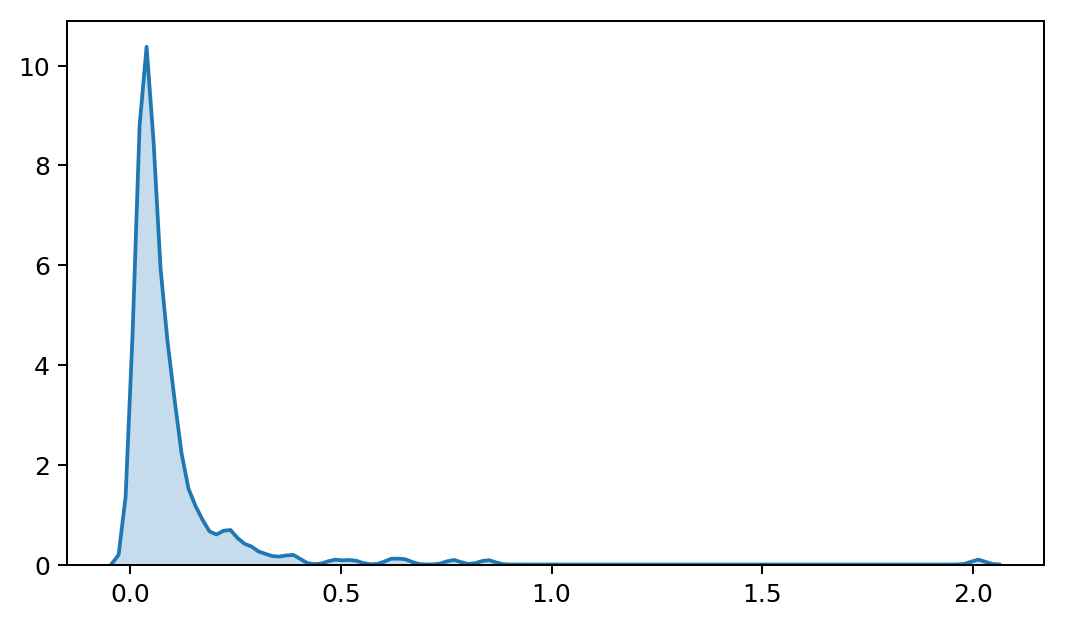

In [42]:
fig, ax = plt.subplots(dpi=180)
sns.kdeplot(branch_lengths, shade=True, ax=ax)
fig.set_size_inches(7,4)

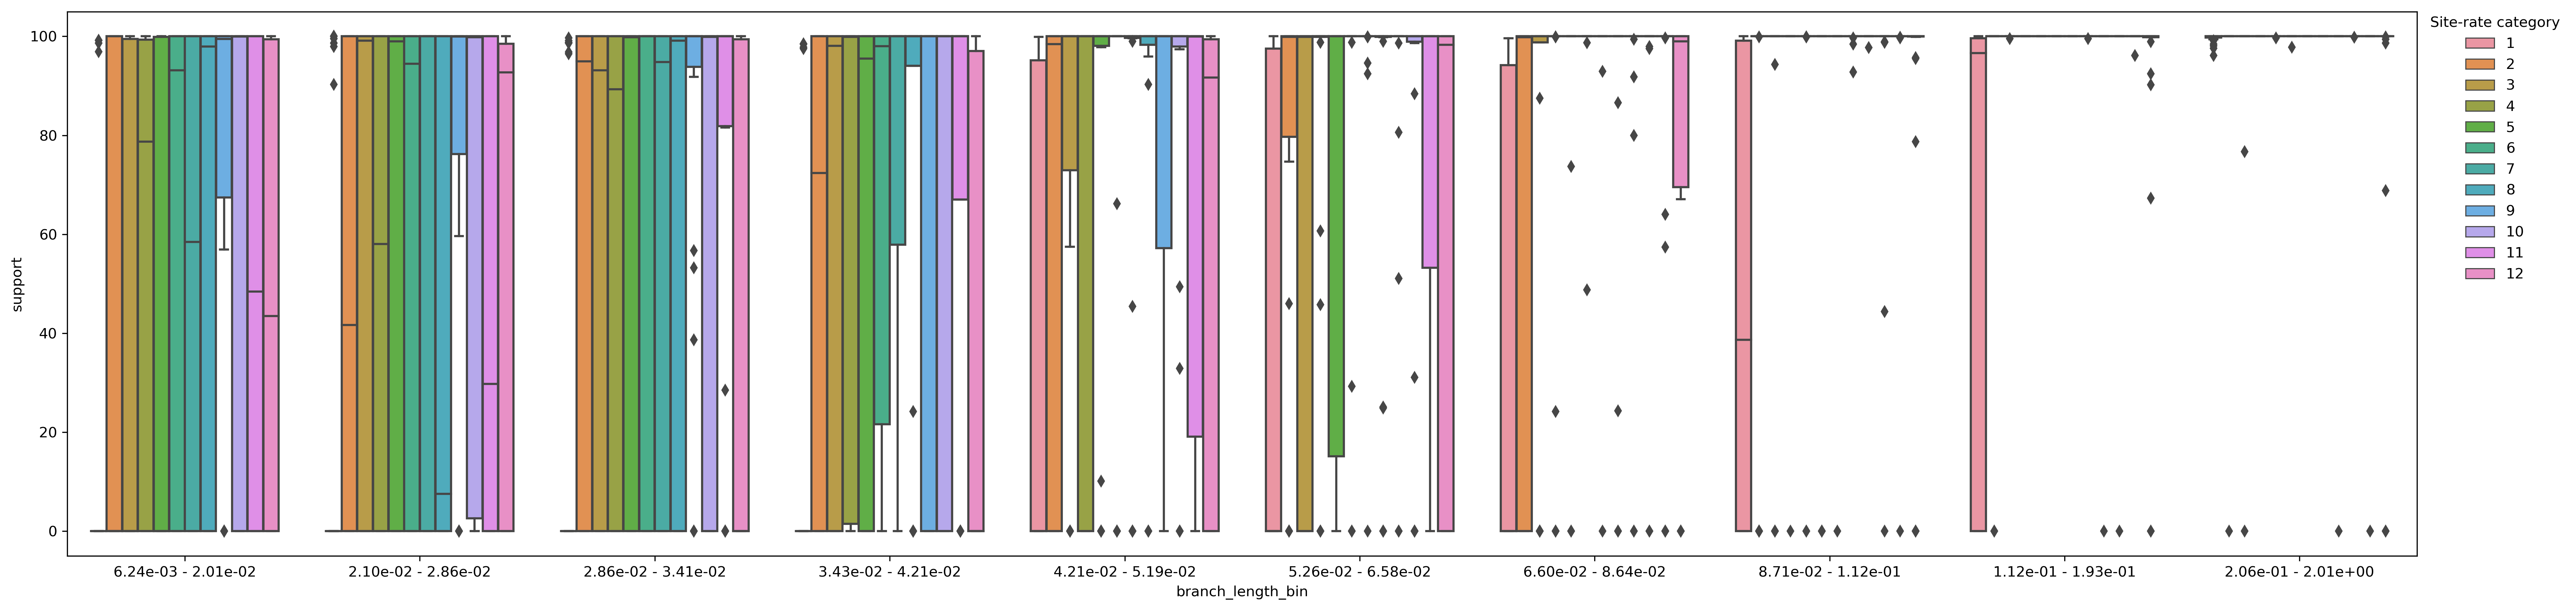

In [43]:
fig, ax = plt.subplots(dpi=300)
sns.boxplot(x='branch_length_bin', y='support', hue='category', order=bin_names.values(), data=category_support_df, ax=ax)
fig.set_size_inches(25,6)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.015), title='Site-rate category',frameon=False)
fig.tight_layout()
#fig.savefig('support_binned_by_branch_length-decile_binned.pdf', dpi=300)
#plt.close()